# Slow feature analysis

### Background

Slow feature analysis (SFA) is a optimization that extracts the slowest-moving features of the signal
![missing image, need to be connected to internet](http://scholarpedia.org/w/images/thumb/c/c5/SlowFeatureAnalysis-SlownessPrinciple.jpeg/400px-SlowFeatureAnalysis-SlownessPrinciple.jpeg "")


![missing image of steps of SFA](http://scholarpedia.org/w/images/thumb/d/df/SlowFeatureAnalysis-Algorithm.png/800px-SlowFeatureAnalysis-Algorithm.png "")

## Sine wave example

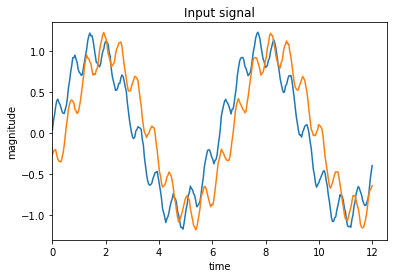

In [19]:
import numpy as np
import matplotlib.pyplot as plt
start = 0
end = 12
nsamples = 300
x = np.linspace(start,end, nsamples)
shift = 0.5
twoD = True
signal = np.sin(x)+0.2*np.sin(10*x)+0.05*np.random.random(x.shape)
if twoD:
    signal_shifted = np.sin(x-shift)+0.2*np.sin(10*(x-shift))+0.05*np.random.random(x.shape)
    signal = np.hstack([signal.reshape(-1,1), signal_shifted.reshape(-1,1)])
#scale to have mean 0 var 1, just for comparison purposes
rescaled_signal = (signal - np.mean(signal, 0)) / np.std(signal, 0)

plt.plot(x,signal)
plt.xlabel("time")
plt.ylabel("magnitude")
plt.title("Input signal")
plt.xlim([0,4*np.pi])
plt.show()

In [20]:
import mdp
'''
@param signal_list n x m array with n points in time that are m dimensional
'''
lookback = 3

def flow(signal_list):
    #put into format where columns are variables and rows are observations
    ndims = signal_list.shape[1]
    flow = (mdp.nodes.EtaComputerNode() +
        mdp.nodes.TimeFramesNode(lookback) +
        mdp.nodes.PolynomialExpansionNode(2) +
        mdp.nodes.SFANode(output_dim=ndims, include_last_sample=True) +
        mdp.nodes.EtaComputerNode() )
    flow.train(signal_list)
    return flow



9 dim
9 dim


ValueError: x and y must have same first dimension, but have shapes (298,) and (598, 1)

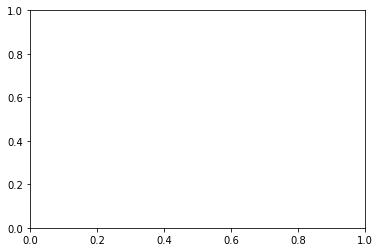

In [21]:
flows = flow(signal.reshape(-1,1))
encoded = flows(signal.reshape(-1,1))

plt.plot(x[:-lookback+1],encoded, label = "output signal")
plt.plot(x, rescaled_signal, label="Rescaled input signal")
plt.xlabel("time")
plt.ylabel("magnitude")
plt.title("output signal")
plt.legend()
plt.xlim([0,4*np.pi])

covariance between the output signal and the rescaled input signal
eta is a measure of the slowness. The lower the value the higher the slowness

In [44]:
print("Covariance", mdp.utils.cov2(rescaled_signal[:-lookback+1], encoded))
print("eta input", flows[0].get_eta(t=len(signal)))

print("eta output", flows[-1].get_eta(t=len(signal)-lookback))

Covariance [[0.99966447]]
eta input [4.31400364]
eta output [3.8792841]


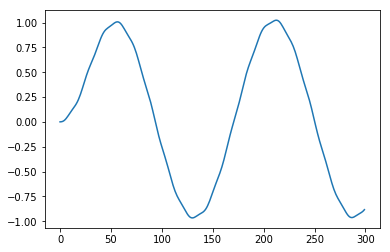

In [45]:
from scipy.signal import butter, lfilter, freqz
order = 2
fs = nsamples/(end-start)
cutoff = 0.4

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y
y = butter_lowpass_filter(data=signal, cutoff=cutoff, fs=fs, order=order)
plt.plot(y)

In [46]:
## SFA on a 2D image activations

In [13]:
import imageio
import numpy as np
from PIL import Image
filename = "video.mp4"
vid = imageio.get_reader(filename,  'ffmpeg')
nframes = 55
size = 6
images = np.zeros((nframes, size*size))
startframe = 500
for num in range(startframe,startframe+nframes):
    image = vid.get_data(num)
    corners = (50,50,56,56)
    image_smaller = Image.fromarray(image).convert("L").resize((200,200)).crop(corners)
    images[num-startframe, :] = list(image_smaller.getdata())
    
images = images/255 + 0.2*np.random.random(images.shape)

In [14]:
flows = flow(images)
encoded = flows(images)

5994 dim
5994 dim


FlowException: 
========================================
While training node #4 (EtaComputerNode):
----------------------------------------
! Exception in node #3 (SFANode):
Node Traceback:
Traceback (most recent call last):
  File "/home/lagrassa/virtualenvs/lismtg/lib/python3.5/site-packages/mdp/utils/_symeig.py", line 75, in wrap_eigh
    return numx_linalg.eigh(**args)
  File "/home/lagrassa/virtualenvs/lismtg/lib/python3.5/site-packages/scipy/linalg/decomp.py", line 493, in eigh
    " computed." % (info-b1.shape[0]))
numpy.linalg.LinAlgError: the leading minor of order 53 of 'b' is not positive definite. The factorization of 'b' could not be completed and no eigenvalues or eigenvectors were computed.

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/lagrassa/virtualenvs/lismtg/lib/python3.5/site-packages/mdp/nodes/sfa_nodes.py", line 152, in _stop_training
    range=rng, overwrite=(not debug))
  File "/home/lagrassa/virtualenvs/lismtg/lib/python3.5/site-packages/mdp/utils/_symeig.py", line 77, in wrap_eigh
    raise SymeigException(str(exception))
mdp.utils._symeig.SymeigException: the leading minor of order 53 of 'b' is not positive definite. The factorization of 'b' could not be completed and no eigenvalues or eigenvectors were computed.

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/lagrassa/virtualenvs/lismtg/lib/python3.5/site-packages/mdp/linear_flows.py", line 348, in _execute_seq
    x = flow[i].execute(x)
  File "<string>", line 1, in <lambda>
  File "/home/lagrassa/virtualenvs/lismtg/lib/python3.5/site-packages/mdp/signal_node.py", line 646, in execute
    self._pre_execution_checks(x)
  File "/home/lagrassa/virtualenvs/lismtg/lib/python3.5/site-packages/mdp/signal_node.py", line 521, in _pre_execution_checks
    self._if_training_stop_training()
  File "/home/lagrassa/virtualenvs/lismtg/lib/python3.5/site-packages/mdp/signal_node.py", line 500, in _if_training_stop_training
    self.stop_training()
  File "<string>", line 1, in <lambda>
  File "/home/lagrassa/virtualenvs/lismtg/lib/python3.5/site-packages/mdp/signal_node.py", line 627, in stop_training
    self._train_seq[self._train_phase][1](*args, **kwargs)
  File "/home/lagrassa/virtualenvs/lismtg/lib/python3.5/site-packages/mdp/nodes/sfa_nodes.py", line 163, in _stop_training
    raise NodeException(errstr)
mdp.NodeException: the leading minor of order 53 of 'b' is not positive definite. The factorization of 'b' could not be completed and no eigenvalues or eigenvectors were computed.
 Covariance matrices may be singular.
----------------------------------------
========================================

# Neural net autoencoder